<a href="https://colab.research.google.com/github/itsalanthomas/shipping-optimization/blob/dev/src/Ecommerce_Optimization_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# load libraries
from google.colab import files
from io import StringIO
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_curve, roc_auc_score


# load data in with file simulation
uploaded = files.upload()
filename = 'ecommerce_shipping_cleaned.csv'

with open(filename, 'r') as file:
  csv_text = file.read()

# create df
df = pd.read_csv(StringIO(csv_text))



Saving ecommerce_shipping_cleaned.csv to ecommerce_shipping_cleaned (7).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Id                          10999 non-null  int64  
 1   Warehouse Block             10999 non-null  object 
 2   Mode Of Shipment            10999 non-null  object 
 3   Customer Care Calls         10999 non-null  int64  
 4   Customer Rating             10999 non-null  int64  
 5   Cost Of The Product         10999 non-null  int64  
 6   Prior Purchases             10999 non-null  int64  
 7   Product Importance          10999 non-null  int64  
 8   Gender                      10999 non-null  object 
 9   Discount Offered            10999 non-null  int64  
 10  Weight In Gms               10999 non-null  int64  
 11  On-Time Delivery            10999 non-null  int64  
 12  Net Price   

In [ ]:
#New features from dataset.
#df['Net Price'] = df['Cost Of The Product'] - df['Discount Offered']
#df['Cost Rate'] = round((df['Cost Of The Product']/df['Discount Offered']), 2)
#df['Status of Mode by Shipment'] = df['Mode Of Shipment'].map(df.groupby('Mode Of Shipment')['On-Time Delivery'].mean())

In [ ]:
#columns to encode and initialize encoder
columns = ['Warehouse Block','Mode Of Shipment', 'Gender']
encoder = pd.get_dummies(df[columns], drop_first=True)
encoder = encoder.astype(int)
df_new = pd.concat([df.drop(columns = columns), encoder], axis=1)

In [ ]:
#Scaling nominal data
scaler = StandardScaler()
columns_to_scale = ['Customer Rating','Cost Of The Product',
                    'Prior Purchases', 'Product Importance',
                    'Discount Offered', 'Weight In Gms',
                    'Net Price','Discount Ratio','Status By Mode Of Shipment']
df_new_scaled = scaler.fit_transform(df_new[columns_to_scale])
df_new_scaled = pd.DataFrame(df_new_scaled, columns = columns_to_scale)
df_new_scaled = pd.concat([df_new.drop(columns = columns_to_scale), df_new_scaled], axis = 1)

In [ ]:
#Checking for multicollinearity values greater than 5 (ignoring the total price since that was created from two other features)
#taking out correlated columns (price ones)
df_vif = df_new_scaled.drop(columns = ['Net Price','Cost Of The Product','Discount Offered','Discount Ratio'])

vif = pd.DataFrame()
vif['feature']  = df_vif.columns
vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
print(vif)

                       feature         VIF
0                           Id    1.374781
1          Customer Care Calls    1.194988
2             On-Time Delivery    1.248506
3            Warehouse Block_B    1.667148
4            Warehouse Block_C    1.667247
5            Warehouse Block_D    1.667487
6            Warehouse Block_F    2.001018
7        Mode Of Shipment_Road  189.262948
8        Mode Of Shipment_Ship    1.673335
9                     Gender_M    1.000572
10             Customer Rating    1.000774
11             Prior Purchases    1.087883
12          Product Importance    1.021170
13               Weight In Gms    1.338183
14  Status By Mode Of Shipment  168.119781


In [ ]:
#Drop the columns that are linearly correlated and target variable.
X = df_new_scaled.drop(columns = ['On-Time Delivery','Cost Of The Product','Discount Offered','Id','Customer Care Calls','Status By Mode Of Shipment'])
y = df_new_scaled['On-Time Delivery']

In [ ]:
#Splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)


In [ ]:
#Create Model
model_logreg = LogisticRegression()

#train model
model_logreg.fit(X_train, y_train)

#predict
y_pred = model_logreg.predict(X_test)

In [ ]:
print('Accuracy:', round(accuracy_score(y_test, y_pred),2))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.63
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.57      0.55      1312
           1       0.70      0.67      0.69      1988

    accuracy                           0.63      3300
   macro avg       0.62      0.62      0.62      3300
weighted avg       0.63      0.63      0.63      3300



In [ ]:
# Compute the confusion matrix
print(confusion_matrix(y_test, y_pred))


[[ 742  570]
 [ 654 1334]]


In [ ]:
#Grid search for hyperparameter search
param_grid = [
    {'penalty': ['l1'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 500]},
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'saga'], 'max_iter': [100, 200, 500]},
    {'penalty': ['elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'l1_ratio': [0.2, 0.5, 0.8], 'max_iter': [100, 200, 500]},
    {'penalty': [None], 'solver': ['saga'], 'max_iter': [100, 200, 500]}
]

In [ ]:
#grid search object
grid_search = GridSearchCV(estimator=model_logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 93 candidates, totalling 465 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 200, 500], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'max_iter': [100, 200, 500], 'penalty': ['l2'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.2, 0.5, 0.8],
                          'max_iter': [100, 200, 500],
                          'penalty': ['elasticnet'], 'solver': ['saga']},
                         {'max_iter': [100, 200, 500], 'penalty': [None],
                          'solver': ['saga']}],
             scoring='accuracy', verbose=1)

In [ ]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", round(grid_search.best_score_,2))

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best Parameters: {'C': 0.01, 'l1_ratio': 0.5, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
Best Cross-Validation Accuracy: 0.64


In [ ]:
# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 709  603]
 [ 600 1388]]

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      1312
           1       0.70      0.70      0.70      1988

    accuracy                           0.64      3300
   macro avg       0.62      0.62      0.62      3300
weighted avg       0.64      0.64      0.64      3300



In [ ]:
#Creating roc curve metrics
y_pred_proba = model_logreg.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc:.2f}")

AUC-ROC: 0.72


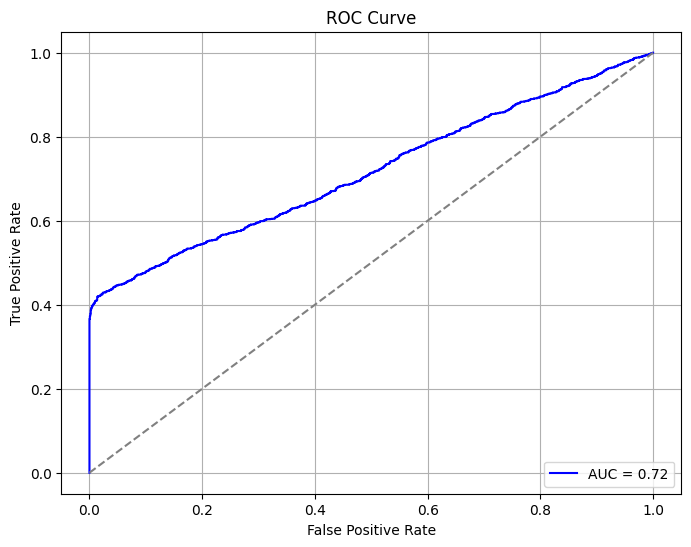

In [ ]:
#creating curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# Get feature importance using coefficients
importances = abs(best_model.coef_[0])
feature_names = X.columns


In [ ]:
#creating df
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

<ipython-input-149-6fb82c2a9761>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


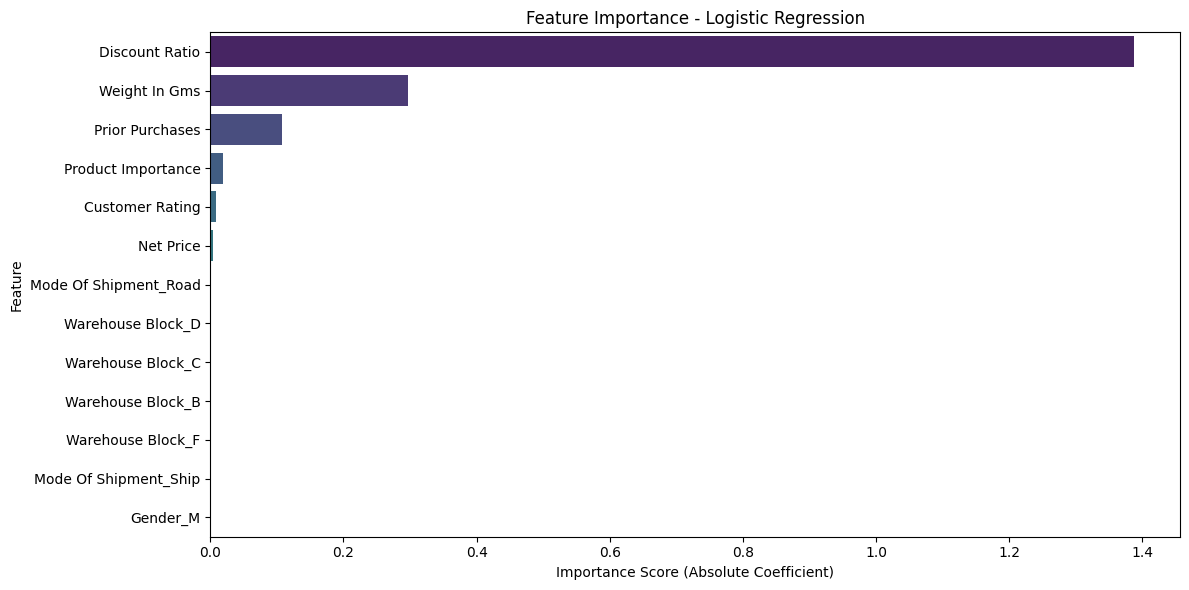

In [ ]:
#plot graph
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importance - Logistic Regression')
plt.xlabel('Importance Score (Absolute Coefficient)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()